<a href="https://colab.research.google.com/github/ChristensenAlex/DataWrangling/blob/main/PrimaryCells.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DS 2500 - Module 01 - Exploring Data Sets

Alex Christensen

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt


import numpy as np
import pandas as pd
import scipy.io
from scipy.optimize import curve_fit
# include library for non-linear regressions
!pip install lmfit
from lmfit.models import ExpressionModel
from lmfit.parameter import Parameters
# allow graphing by color
import seaborn as sb

     |████████████████████████████████| 307kB 11.9MB/s 
     |████████████████████████████████| 61kB 6.2MB/s 
     |████████████████████████████████| 256kB 49.5MB/s 
  Created wheel for lmfit: filename=lmfit-1.0.2-cp37-none-any.whl size=85265 sha256=43dc278e0449471c5a9ddf14d686226170f0a9ea94bf137713abd383751251a1
  Stored in directory: /root/.cache/pip/wheels/d4/5e/db/d9f5987d9f15bf910feb5e0274ac601d5f2161dc78aedfacfa
  Created wheel for asteval: filename=asteval-0.9.23-cp37-none-any.whl size=17419 sha256=8900814bb72afb6f17b6c94dec3a8a77c8246817165436427b67ffc59edeaa2b
  Stored in directory: /root/.cache/pip/wheels/56/d6/43/4b5d8a9fd98b976031768673658c8b8d08dc9dcc0fa1907ad0
Successfully built lmfit asteval


**Background**

I have a grant through the office of undergraduate research to evaluate cell growth models. My PI, Thomas Zangle, said I can use these datasets for this class.

**Definitions**

Immortalized cells - cells that continously keep dividing. These are stable and will divide forever e.g. HeLa cells (cervical cancer), and most other cancers.

Primary cells - cells taken from living tissue. They only divide for a short time before dying.

**Background for the dataset - Feel free to skip this section. In short my lab has a novel way to measure the mass of an individual cell.**

My PI creates quantitative phase microscope to measure cell mass. The definition of a laser is light that is both monochromatic (one wavelength) and coherent (the light waves are in sync). When a laser is shined through a cell, the laser will phase shift proportional to the mass of the cell. We can measure the phase shifting using diffraction grating in front of photoresistors. The lab has image processing software that takes phase shifting and provides pictures of the cells, then finds the cells and tracks them until they divide. In short, we weigh cells by taking pictures of them. Weighing an individual cell is difficult because the measurement's uncertainty is larger than the mass we are measuring, but our technique is quite accurate ~5 pg which is good enough to track individual cells.

**Previous research - Researchers agree that larger cells grow faster, which agree with exponential fitting. But new research suggest a better model.**

Historically, there are two main camps of cell growth models. One camp believes cells accumulate mass linearly e.g. cells produce proteins at a constant speed over the lifecycle. The other camp believes cells grow exponentially e.g. large cells have more ribosomes hence produce proteins faster than small cells. But this speculation has been put to rest at least for mammalian cells. All researchers in the field of measuring mammalian cell mass agree larger cells grow faster hence use exponential models to fit data.

Our lab received Primary B cells from mice. These cells increase mass by 500% before dividing, more than the standard 200% increase of immortalized cells. When we look at these cells, the exponential fit is no longer adequate. We decided to evaluate a combination of both exponential and linear models. 

**A bit of differential equations behind the models - In short, an exponential + constant model is a combination of both the exponential and linear model** 

In linear growth, the mass accumulation depends on a constant. 

dm/dt = C

When the differential equation is solved it gives a line.

m = Ct + D 

In exponential growth, the mass accumulation is proportional to the mass.

dm/dt = bm 

When the differential equation is solved it gives an exponent.

m = Ae^(bt) 

When accounting for both linear and exponential growth.

dm/dt = bm + C 

It solves to an exponent plus a constant. 

m = Ae^(b*t) - C/b 

If exponential plus a constant fits better then it some proteins are produced at a constant rate while other proteins are produced faster in large cells.
**Important point: Staring with a differential equation that accounts for both exponetial and linear growth gives a model that is exponential + constant**


**Question**

Can the exponential growth model be improved by adding a constant (which represents the linear component)?

e.i. Is m = A*e^(b*t) or m = A*e^(b*t) - C/b a better model?

 Where negative C/b is a constant and can be lumped together.


**Read in my data**

In [ ]:
# Import the data
#df = pd.read_excel('https://www.dropbox.com/s/1x4mrhipukvgdrn/Immortalized%20Cells.xlsx?dl=1')
df = pd.read_excel('https://www.dropbox.com/s/md8vurae2utmwku/CellData.xlsx?dl=1')


**Check the packaging**

In [ ]:
df.shape

(20652, 3)

**Look at top and bottom of data**

In [ ]:
df.head()

,Cell Number,Time (hr),Mass (pg)
0,1,0.000000,22.094191
1,1,0.041667,21.353989
2,1,0.083611,21.852442
3,1,0.125278,22.460304
4,1,0.167500,22.229605


In [ ]:
df.tail()

,Cell Number,Time (hr),Mass (pg)
20647,29,36.293611,115.325836
20648,29,36.334722,118.581680
20649,29,36.376944,116.864723
20650,29,36.418056,119.971497
20651,29,36.461667,122.381020


Looks good. It has the cell number, time in hours, and mass in picograms

**Check the "n"s**

There should be 29 unique cells.

In [ ]:
df['Cell Number'].value_counts().sort_index()

1     840
2     690
3     543
4     914
5     777
6     465
7     605
8     653
9     599
10    915
11    713
12    273
13    892
14    662
15    986
16    576
17    747
18    840
19    827
20    980
21    770
22    597
23    612
24    737
25    888
26    606
27    520
28    549
29    876
Name: Cell Number, dtype: int64

**Validate against an external data source**

Most cells take about 30 hours to divide.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fad09439a10>],
      dtype=object)

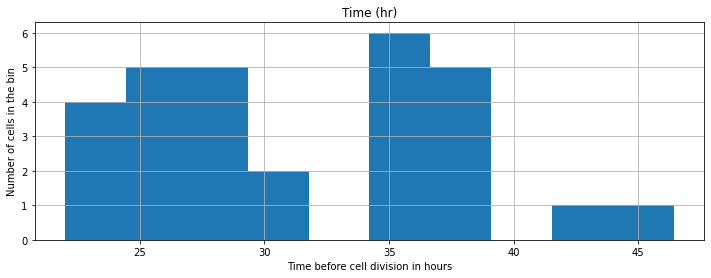

In [ ]:
firstdata = df.groupby(['Cell Number']).min()
lastdata = df.groupby(['Cell Number']).max()
f,ax = plt.subplots(1,1,figsize=(12,4))
ax.set_xlabel("Time before cell division in hours")
ax.set_ylabel("Number of cells in the bin")
ax.set_title("Histogram of length of cell cycle")
lastdata[['Time (hr)']].hist(ax=ax)

Looks good. The cells live for roughly 30 hours before dividing

Cells should increase their mass by roughly 5 times

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fad07af4290>],
      dtype=object)

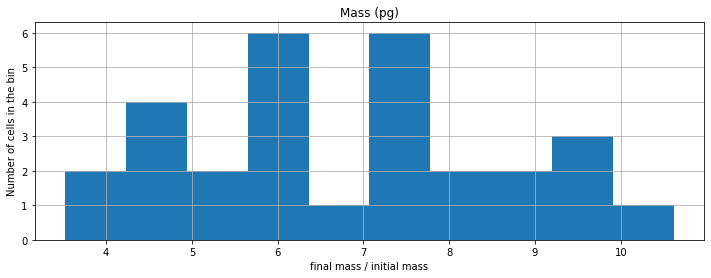

In [ ]:
f,ax = plt.subplots(1,1,figsize=(12,4))
ax.set_xlabel("final mass / initial mass")
ax.set_ylabel("Number of cells in the bin")
ax.set_title("Histogram of Mass Ratios")
(lastdata / firstdata)[['Mass (pg)']].hist(ax=ax)

Looks good. The cell mass ratio was a bit higher than I expected. But this is because of noise in the data. The minimum mass value is a bit lower than the average beginning mass value (because at least one value will be less than the actual starting mass) similarly at least one mass values will be larger than the true actual final mass. These two effects artifically increase the mass ratio above 5.

**Make a plot**

I want to plot all the cells. The seaborn library does this well.

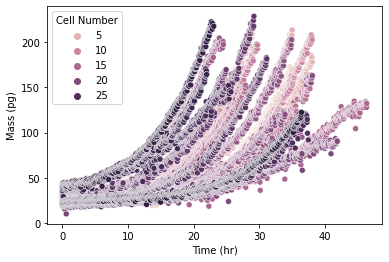

In [ ]:
sb.scatterplot(x='Time (hr)',y='Mass (pg)',hue='Cell Number',data=df)

Lets look at a single cell.

In [ ]:
# CHANGE THE NEXT LINE TO LOOK AT 
Cell_to_analyze = 5 # Change this number to any value between 1 and 29.
dfSingle = df[df['Cell Number'] == Cell_to_analyze]

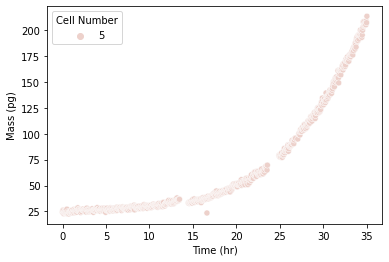

In [ ]:
# graph a single cell
sb.scatterplot(x='Time (hr)',y='Mass (pg)',hue='Cell Number',data=dfSingle)

Note that some cells have missing data. The autotracking software sometimes loses track of the cell.

**Try an easy solution**

Can we visually see a difference between the two models?

Fit an exponential.

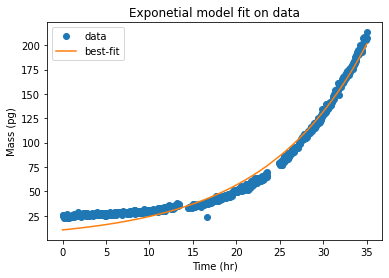

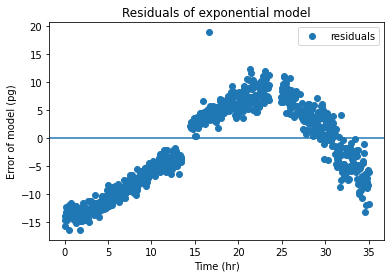

In [ ]:
exponentialmodel = ExpressionModel('A * exp(b*x)')
'N'
params = exponentialmodel.make_params(A=20, b=0.13)
ex_result = exponentialmodel.fit(dfSingle['Mass (pg)'], params, x=dfSingle['Time (hr)'])
ex_result.plot_fit()
plt.title("Exponetial model fit on data")
plt.xlabel("Time (hr)")
plt.ylabel("Mass (pg)")
plt.show()
ex_result.plot_residuals()
plt.title("Residuals of exponential model")
plt.xlabel("Time (hr)")
plt.ylabel("Error of model (pg)")
plt.show()
# Uncomment this next line to look at the statistics. Notice that the AIC, BIC, and chi squared values are higher for the exponential model.
#print(ex_result.fit_report())


Fit an exponential plus constant

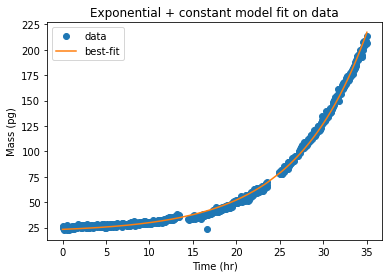

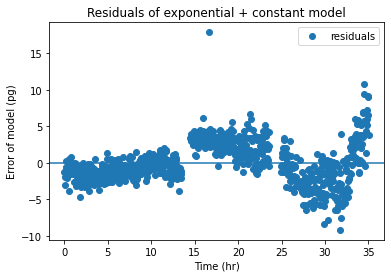

[[Model]]
    Model(_eval)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 777
    # variables        = 3
    chi-square         = 6075.34712
    reduced chi-square = 7.84928568
    Akaike info crit   = 1603.94250
    Bayesian info crit = 1617.90882
[[Variables]]
    A:  2.79207959 +/- 0.05988571 (2.14%) (init = 5)
    b:  0.12142947 +/- 6.2744e-04 (0.52%) (init = 0.13)
    C:  20.4021016 +/- 0.22904476 (1.12%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(A, b) = -0.996
    C(A, C) = -0.841
    C(b, C) =  0.809


In [ ]:
exponentialPlusConstantmodel = ExpressionModel('A * exp(b*x) + C')

params = exponentialPlusConstantmodel.make_params(A=5, b=0.13, C=20)
C_result = exponentialPlusConstantmodel.fit(dfSingle['Mass (pg)'], params, x=dfSingle['Time (hr)'])
C_result.plot_fit()
plt.xlabel("Time (hr)")
plt.ylabel("Mass (pg)")
plt.title("Exponential + constant model fit on data")
plt.show()
C_result.plot_residuals()
plt.title("Residuals of exponential + constant model")
plt.xlabel("Time (hr)")
plt.ylabel("Error of model (pg)")
plt.show()
# Uncomment this next line to look at the statistics. Notice that the AIC, BIC, and chi squared values are much less for the exponential + constant model.
print(C_result.fit_report())

The exponential + constant model has lower residuals for most cells, But lets double check using the realitive likelihood AIC test. This test was found at wikipedia https://en.wikipedia.org/wiki/Akaike_information_criterion#How_to_use_AIC_in_practice. 

relative likelihood = exp((AIC_lower - AIC_higher)/2)

The lower the relative likelihood then the more probable that the exponential + constant fit is better.

In [ ]:
relative_liklihood = np.e**((C_result.aic - ex_result.aic)/2)
print("The likehood that the exponential model is better than exponential plus constant model is " + str(relative_liklihood))

The likehood that the exponential model is better than exponential plus constant model is 0.12119518681694227


The relative likelyhood is incredibly small for most cells. It even rounds to zero sometimes. The exponential + constant model is better than exponential at describing this data.

**Module 1 write-up**

**Question**

**Why this question is important**

If cells grow exponentially then all mass contributes to cell growth. In contrast if exponential + constant is a better model then some mass is inactive to growing the cell e.g., does all cell mass become proteins such as ribosomes that produce proteins or does some cell mass not contribute to cell growth. If exponential + constant is a better model than both exponential and linear models need to be accounted for when properly chacterizing cell growth. Interestingly, the linear term lowers cell growth. These cells grow slower than predicted by exponential growth, by adding a linear term we account for this slower growth.

**Why my results matter**

With a single cell, the evidence is overwhelming that an exponential plus constant model is better at describing mass over time data for these mammllian cells. The result is clear because of this data is less noisy than standard mammalian cell lines in two ways, 1) the technique to measure the mass is fairly accurate, 2) these cells increase their mass by 5-fold times rather than 2-fold in most immoratized cells.

The question is specific. Namely which of those two models better describe the data. This question is alligned well with the dataset. The dataset has mass and time values for mamillian cells. This is the exact type of question to ask this dataset. The results are interesting. This is generally unknown in literature, as most people assume individual mamillian cells grow exponentially. The goal is to publish a paper on this result. But we have two main questions to answer first. 1) Why no one was discovered this before. *Simulations suggest this effect can only be seen on individual cells if the data has low uncertainty and cells more than double their initial mass.* 2) If we aggregate cells do we see this effect on other cell types.

The question is answerable and was answered in the analsis. The data is clear that including a constant term to the exponential improves the fitting of the model.

**Visualization**

**Less important visualizations**

Histogram of cell cycle length - Most cells divide at about 30 hours. A histogram is a bit nicer to look at than a table.

Histogram of mass ratio - Most cells increase mass by 5 times. A histogram is a bit nicer to look at than a table.

Graph of all cells mass over time - The reader can see that cells are different from each other and need to be fit with different parameters. The cells cannot share one set of parameters on the model. For the rest of the analysis I will use only one cell.

Graph of single cell mass over time - this shows if the data is missing as the autotracker sometimes loses track of the cell.

**More important visualizations**

Exponential fit on data - This shows how the exponetial model is systematically off. The exponential fit goes outside the natural variance of data. That is a clue that the model has poor fit.

Residual of exponential fit - This more clearly shows that an exponential fit is systemically off. It doesn't follow the underlying bias of the data. This also can be compared with the residual plot from exponential + constant model.

Exponential + constant fit on data - This model stays within the natural variation of the data. It visually fits better than the exponential.

Residual of exponential + constant fit - If you look at the y-axis, the residuals are less. The crux of this whole analysis is: you can visually see the residuals are less for the exponential + constant model.

**Test**

I used the alkaike information criteria (AIC). The AIC is meaningless by itself. The value changes depending on the scaling e.g., if I measured mass in grams rather than picograms the the AIC values would be less. But AIC can be used to calculate the relative likehood of two models. This relative likehood is meaningful and won't change if I measure mass in grams or picograms. The relative liklihood equation was found at wikipedia https://en.wikipedia.org/wiki/Akaike_information_criterion#How_to_use_AIC_in_practice.

relative likelihood = exp((AIC_lower - AIC_higher)/2)

Likehood is predicting a model given an outcome. This is the opposite of probablility which is predicting an outcome given a model. For example, probability is assuming a fair dice, what is the chance of rolling three 1's in a row. Likehood is given three 1's in a row was the dice fair. The relative likehood is the ratio of likehood of two hypotheses e.i. if the exponential model had a 1% of giving the output and an exponential + constant model had a 2% chance of giving an output. Then the relative likehood between the two models is 1:2. Since the first hypothesis is half as likely to give that output than the second hypothesis. For most of the cells in this analysis, the relative likehood is very low, 10^-50. This means that the exponential + constant model is a much more likily explaination.
My description of likehood was inspired from https://arbital.com/p/relative_likelihood/. 

**Acknowledgement**

I want to thank the office of undergraduate research (OUR) at the University of Utah for funding this research, Thomas Zangle (PI) for letting me work in his lab, and Jingzhou Zhang (Ph.D candidate) for gathering/sharing his data.


